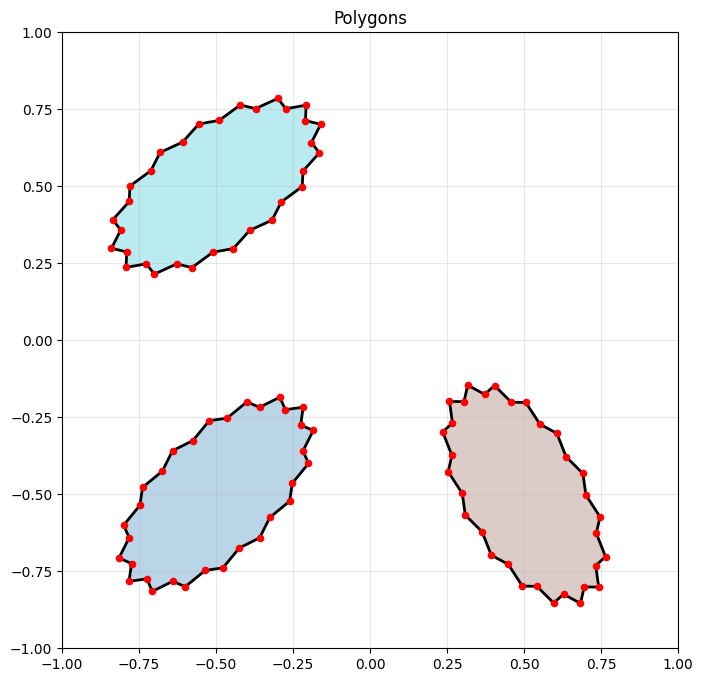

In [5]:
from neural_spline.types import ConvexPolytope, PCAComponent
from neural_spline.polygons import generate_polygons
from neural_spline.vis import plot_polygons
import numpy as np

polygons = generate_polygons('3x16', convex=False, stretch=(1, 0.5), 
                             star_ratio=0.9, rotation=[np.pi/4, -np.pi/3, np.pi/5])

plot_polygons(polygons)

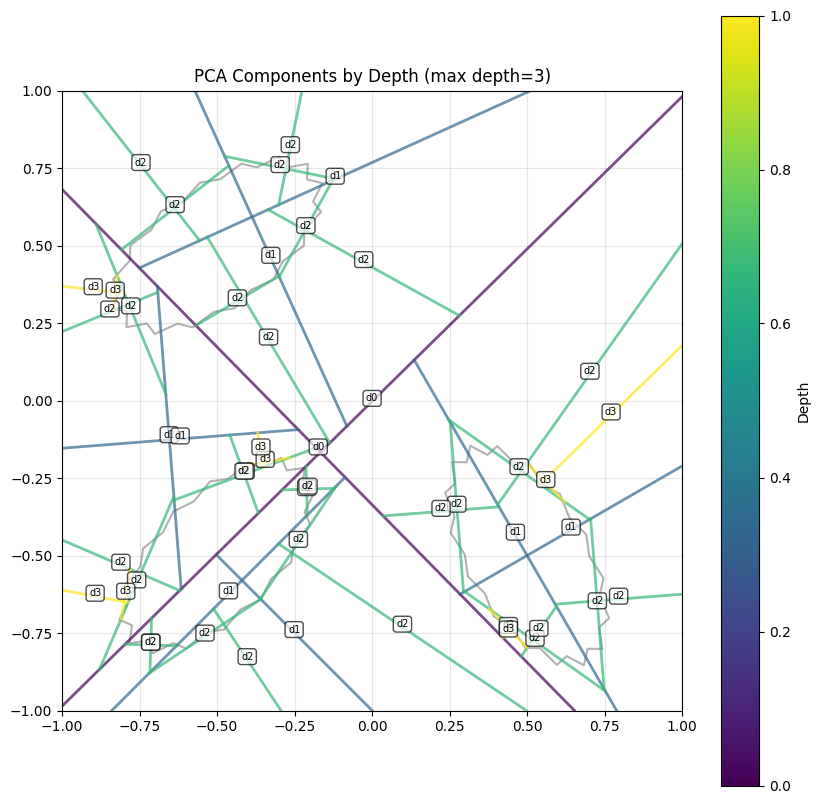

In [6]:
from neural_spline.geometry import constrained_recursive_pca, flatten_pca_tree
import torch
import matplotlib.pyplot as plt

def plot_pca_by_depth(polygons, node, figsize=(10, 10)):
    """Plot PCA components colored by recursion depth."""
    plt.figure(figsize=figsize)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Plot polygons
    for polygon in polygons:
        closed_poly = np.vstack([polygon, polygon[0:1]])
        plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=1.5, alpha=0.3)
    
    # Get components and max depth
    components = flatten_pca_tree(node)
    max_depth = max(c.depth for c in components)
    
    # Plot components colored by depth
    for comp in components:
        start = comp.start.cpu().numpy()
        end = comp.end.cpu().numpy()
        
        # Color by depth (deeper = more purple)
        color = plt.cm.viridis(comp.depth / max_depth)
        
        plt.plot([start[0], end[0]], [start[1], end[1]], 
                color=color, linewidth=2, alpha=0.7)
        
        # Add depth annotation at midpoint
        mid = (start + end) / 2
        plt.text(mid[0], mid[1], f'd{comp.depth}', 
                fontsize=7, ha='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    plt.title(f'PCA Components by Depth (max depth={max_depth})')
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), 
                label='Depth', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    plt.show()

vertices = np.concatenate(polygons, axis=0)
vertices = torch.from_numpy(vertices).float()
node = constrained_recursive_pca(vertices, max_depth=100)

plot_pca_by_depth(polygons, node)

In [17]:
from pytorch3d.io import load_ply
import plotly.graph_objects as go

def plot_pca_plotly(mesh_vertices, mesh_faces, node):
    """Plotly with FULL free rotation (not locked to Z-axis)."""
    if isinstance(mesh_vertices, torch.Tensor):
        mesh_vertices = mesh_vertices.cpu().numpy()
    if isinstance(mesh_faces, torch.Tensor):
        mesh_faces = mesh_faces.cpu().numpy()
    
    components = flatten_pca_tree(node)
    max_depth = max(c.depth for c in components) if components else 1
    
    fig = go.Figure()
    
    # Mesh
    fig.add_trace(go.Mesh3d(
        x=mesh_vertices[:, 0],
        y=mesh_vertices[:, 1],
        z=mesh_vertices[:, 2],
        i=mesh_faces[:, 0],
        j=mesh_faces[:, 1],
        k=mesh_faces[:, 2],
        opacity=0.3,
        color='lightgray',
        flatshading=True
    ))
    
    # PCA components
    for comp in components:
        start = comp.start.cpu().numpy()
        end = comp.end.cpu().numpy()
        
        color_val = comp.depth / max_depth
        color_rgb = plt.cm.viridis(color_val)[:3]
        color_str = f'rgb({int(color_rgb[0]*255)}, {int(color_rgb[1]*255)}, {int(color_rgb[2]*255)})'
        
        fig.add_trace(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode='lines+markers',
            line=dict(width=6, color=color_str),
            marker=dict(size=5),
            showlegend=False,
            hovertext=f"{comp.label}<br>Depth: {comp.depth}"
        ))
    
    fig.update_layout(
        width=800,   # Square aspect
        height=800,
        scene=dict(
            aspectmode='cube',  # Force cube aspect ratio
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
            camera=dict(
                center=dict(x=0, y=0, z=0),
                up=dict(x=0, y=0, z=1)
            ),
            dragmode='orbit'
        )
    )
    # Enable scrollZoom for better control
    fig.show(config={
        'scrollZoom': True,
        'displayModeBar': True,
        'displaylogo': False
    })
    
    # return fig
mesh_path = 'data/meshes/Armadillo.ply'
verts, faces = load_ply(mesh_path)
# Normalize mesh to [-1, 1] with padding (keep as tensor)
padding = 0.1
centroid = verts.mean(dim=0)
verts = verts - centroid

# Compute extents
min_coords = verts.min(dim=0)[0]
max_coords = verts.max(dim=0)[0]
extents = max_coords - min_coords
max_extent = extents.max().item()

if max_extent > 0:
    scale = 2.0 * (1.0 - padding) / max_extent
    verts = verts * scale

node = constrained_recursive_pca(verts, max_depth=5, min_points=15)
len(flatten_pca_tree(node))

# plot_pca_plotly(verts, faces, node)

11982

In [ ]:
from neural_spline.spline import compute_splines



pca_components = flatten_pca_tree(node)
splines = compute_splines(
    components=pca_components,
    data=data,
    n_samples_per_unit=1000,
    device_id=0
)


15584

In [8]:
from neural_spline.fields import compute_sdf


components = flatten_pca_tree(node)

data = {
    'type': '3d',
    'verts': verts,
    'faces': faces,
    'vertices': vertices
}

t_values_list, sdf_values_list = compute_sdf(
    components=components,
    data=data,
    n_samples_per_unit=1000,
    device_id=0
)

Sampling 50000 points from 3D mesh...
Computing 3D SDF for 15584 segments using 50000 surface points...
  Max 2090 samples per segment...
  Computing distances for 32,570,560 points...


OutOfMemoryError: CUDA out of memory. Tried to allocate 27.94 GiB. GPU 0 has a total capacity of 31.36 GiB of which 2.09 GiB is free. Including non-PyTorch memory, this process has 29.25 GiB memory in use. Of the allocated memory 28.67 GiB is allocated by PyTorch, and 6.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://docs.pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf)

Also the first issues arises for 3d with large small min_points or large max_depth this is very slow, potentially a bottle neck

## Load Trained ReLU MLP Model

Now let's load a trained model and visualize the learned SDF using marching cubes. 

In [ ]:
from neural_spline.model import ReluMLP
import json

# Load config
config_path = 'data/experiments/3d/20260118_145240/config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Create model with same architecture
model = ReluMLP(
    input_dim=config['input_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers']
)

# Load trained weights from checkpoint
model_path = 'data/experiments/3d/20260118_145240/best_model_fast.pt'
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from {model_path}")
print(f"Architecture: {config['num_layers']} layers, {config['hidden_dim']} hidden dim")
print(f"Trained on {config['model']} mesh")
print(f"Checkpoint epoch: {checkpoint['epoch']}, loss: {checkpoint['loss']:.6f}")

Loaded model from data/experiments/3d/20260118_145240/best_model_fast.pt
Architecture: 4 layers, 32 hidden dim
Trained on Armadillo mesh
Checkpoint epoch: 194, loss: 0.001693


In [ ]:
from skimage import measure
import numpy as np
import torch
# Create a 3D grid for evaluation
resolution = 128
x = np.linspace(-1, 1, resolution)
y = np.linspace(-1, 1, resolution)
z = np.linspace(-1, 1, resolution)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Flatten grid for batch evaluation
grid_points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)
grid_tensor = torch.from_numpy(grid_points).float()

# Evaluate model on grid
print(f"Evaluating model on {resolution}^3 grid ({len(grid_points):,} points)...")
with torch.no_grad():
    sdf_values = model(grid_tensor).squeeze().numpy()

# Reshape to 3D grid
sdf_grid = sdf_values.reshape(resolution, resolution, resolution)

print(f"SDF range: [{sdf_grid.min():.4f}, {sdf_grid.max():.4f}]")

# Extract isosurface at level 0 using marching cubes
print("Running marching cubes...")
vertices_mc, faces_mc, normals_mc, _ = measure.marching_cubes(sdf_grid, level=0.0, spacing=(2/resolution, 2/resolution, 2/resolution))

# Shift vertices to center at origin (they start at -1)
vertices_mc -= 1.0

print(f"Extracted mesh: {len(vertices_mc):,} vertices, {len(faces_mc):,} faces")

Evaluating model on 128^3 grid (2,097,152 points)...
SDF range: [-0.3124, 1.2138]
Running marching cubes...
Extracted mesh: 38,182 vertices, 76,180 faces


In [ ]:
import plotly.graph_objects as go

# Create plotly figure
fig = go.Figure()

# Add the extracted mesh
fig.add_trace(go.Mesh3d(
    x=vertices_mc[:, 0],
    y=vertices_mc[:, 1],
    z=vertices_mc[:, 2],
    i=faces_mc[:, 0],
    j=faces_mc[:, 1],
    k=faces_mc[:, 2],
    opacity=0.8,
    color='lightblue',
    flatshading=True,
    lighting=dict(
        ambient=0.5,
        diffuse=0.8,
        fresnel=0.2,
        specular=0.5,
        roughness=0.5
    )
))

# Update layout for nice visualization
fig.update_layout(
    title=f"Learned SDF: {config['model']} (Marching Cubes)",
    width=800,
    height=800,
    scene=dict(
        aspectmode='cube',
        xaxis=dict(title='X', range=[-1, 1]),
        yaxis=dict(title='Y', range=[-1, 1]),
        zaxis=dict(title='Z', range=[-1, 1]),
        camera=dict(
            center=dict(x=0, y=0, z=0),
            up=dict(x=0, y=0, z=1),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        dragmode='orbit'
    )
)

fig.show(config={
    'scrollZoom': True,
    'displayModeBar': True,
    'displaylogo': False
})

In [ ]:
from pytorch3d.io import save_ply
import os

# Save the extracted mesh to a PLY file
output_dir = 'data/experiments/3d/20260118_145240'
output_path = os.path.join(output_dir, 'reconstructed_mesh.ply')

# Convert to torch tensors for pytorch3d (use .copy() to handle negative strides)
vertices_torch = torch.from_numpy(vertices_mc.copy()).float()
faces_torch = torch.from_numpy(faces_mc.copy()).long()

# Save mesh
save_ply(output_path, verts=vertices_torch, faces=faces_torch)

print(f"Saved reconstructed mesh to: {output_path}")
print(f"Vertices: {len(vertices_mc):,}, Faces: {len(faces_mc):,}")

Saved reconstructed mesh to: data/experiments/3d/20260118_145240/reconstructed_mesh.ply
Vertices: 38,182, Faces: 76,180
